This notebook creates a few extra plots that are used in the executive summary but not in the actual report.

In [4]:
from astroclip.utils import load_config, format_axes
from astroclip.training_utils import create_dataloaders, download_desi_dataset
import matplotlib.pyplot as plt

import torch
import numpy as np

In [5]:
config, hparams = load_config('local', 'generate_embeddings')

cache_dir = config['cache_dir']
output_dir = config['output_dir']

batch_size = hparams['batch_size']
num_workers = config['num_workers']

dataset = download_desi_dataset(cache_dir)

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Loading dataset shards:   0%|          | 0/80 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
class ToRGB:
    """
    Transformation from raw image data (g, r, z) to the rgb values displayed at the legacy
    viewer https://www.legacysurvey.org/viewer

    Code copied from https://github.com/legacysurvey/imagine

    Code has been slightly edited to handle different shaped inputs, but is mainly identical.
    """

    def __init__(self, scales=None, m=0.03, Q=20, bands=['g', 'r', 'z']):
        rgb_scales = {
            'u': (2, 1.5),
            'g': (2, 6.0),
            'r': (1, 3.4),
            'i': (0, 1.0),
            'z': (0, 2.2),
        }
        if scales is not None:
            rgb_scales.update(scales)

        self.rgb_scales = rgb_scales
        self.m = m
        self.Q = Q
        self.bands = bands
        self.axes, self.scales = zip(*[rgb_scales[bands[i]] for i in range(len(bands))])

        # rearange scales to correspond to image channels after swapping
        self.scales = [self.scales[i] for i in self.axes]

    def __call__(self, imgs):
        # the below two lines have been added to handle a batch of images
        if len(imgs.shape) == 4:
            return np.stack([self(imgs[i]) for i in range(imgs.shape[0])])

        # Check image shape and set to C x H x W
        if imgs.shape[0] != len(self.bands):
            imgs = np.transpose(imgs, (2, 0, 1))

        I = 0
        for img, band in zip(imgs, self.bands):
            plane, scale = self.rgb_scales[band]
            img = np.maximum(0, img * scale + self.m)
            I = I + img
        I /= len(self.bands)

        Q = 20
        fI = np.arcsinh(Q * I) / np.sqrt(Q)
        I += (I == 0.0) * 1e-6
        H, W = I.shape
        rgb = np.zeros((H, W, 3), np.float32)
        for img, band in zip(imgs, self.bands):
            plane, scale = self.rgb_scales[band]
            rgb[:, :, plane] = (img * scale + self.m) * fI / I

        rgb = np.clip(rgb, 0, 1)

        return rgb

## Plot Some Example Spectra

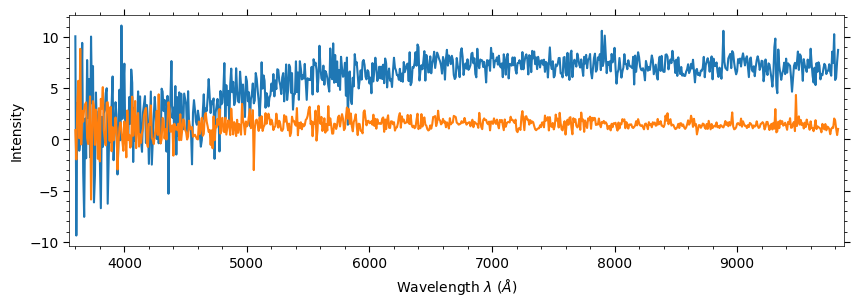

In [135]:
samples = dataset['train'].select([7108, 92292])
fig, ax = plt.subplots(figsize=(10, 3), nrows=1, ncols=1)

subset = np.arange(0, 7781, 10)
wavelengths = np.linspace(3600.0, 9824.0, 7781)

for sample in samples:
    plt.plot(wavelengths[subset], sample['spectrum'][subset])
    
plt.xlabel(r'Wavelength $\lambda$ ($\AA$)')
plt.ylabel('Intensity')
plt.xlim(3600 - 50, 9824 + 50)
format_axes(ax)

plt.savefig('figures/example_spectra.png', bbox_inches='tight')

## Generate Illustration of Bandpass Filters

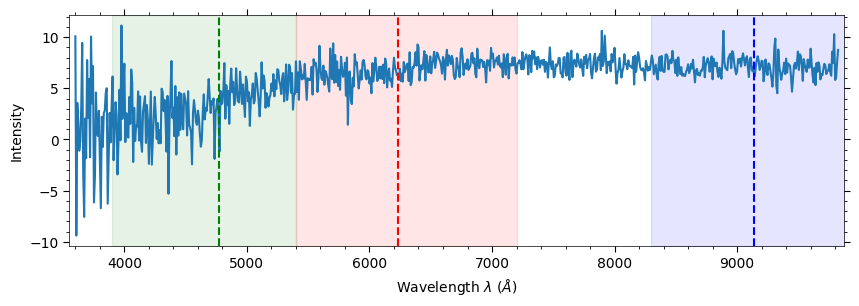

In [136]:
sample = dataset['train'].select([7108])[0]
fig, ax = plt.subplots(figsize=(10, 3), nrows=1, ncols=1)

subset = np.arange(0, 7781, 10)
wavelengths = np.linspace(3600.0, 9824.0, 7781)

plt.plot(wavelengths[subset], sample['spectrum'][subset])
    
plt.xlabel(r'Wavelength $\lambda$ ($\AA$)')
plt.ylabel('Intensity')
plt.xlim(3600 - 50, 9824 + 50)

g = 4770
r = 6231
z = 9134

y_lims = ax.get_ylim()
x_lims = ax.get_xlim()

plt.axvline(g, color='green', linestyle='--', label='g-band')
plt.axvline(r, color='red', linestyle='--', label='r-band')
plt.axvline(z, color='blue', linestyle='--', label='z-band')

plt.fill_betweenx(y_lims, 3900, 5400, color='green', alpha=0.1)
plt.fill_betweenx(y_lims, 5400, 7200, color='red', alpha=0.1)
plt.fill_betweenx(y_lims, 8300, 10100, color='blue', alpha=0.1)

plt.ylim(y_lims)
plt.xlim(x_lims)
format_axes(ax)
plt.savefig('figures/bandpass_filters.png', bbox_inches='tight')

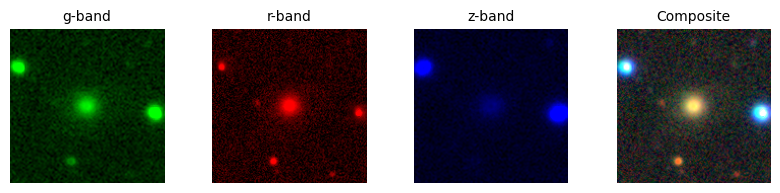

In [123]:
fig, ax = plt.subplots(figsize=(10, 2), nrows=1, ncols=4)

image = ToRGB()(sample['image'])
zeros = np.zeros_like(image[:, :, 0])

ax[0].imshow(np.stack([zeros, image[:, :, 1], zeros], axis=-1))
ax[1].imshow(np.stack([image[:, :, 0], zeros, zeros], axis=-1))
ax[2].imshow(np.stack([zeros, zeros, image[:, :, 2]], axis=-1))
ax[3].imshow(image)

ax[0].set_title('g-band', fontsize=10)
ax[1].set_title('r-band', fontsize=10)
ax[2].set_title('z-band', fontsize=10)
ax[3].set_title('Composite', fontsize=10)

[ax[i].axis('off') for i in range(4)]
plt.savefig('figures/bandpass_filters_image.png', bbox_inches='tight')